In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from utils import label_map_util
from utils import visualization_utils as vis_util
from matplotlib import pyplot as plt
from PIL import Image

/Users/r10138/anaconda3/envs/tensorflow35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
%matplotlib inline
sys.path.append("..")

#### Lesen der gespeicherten TensorFlow Modells
Modelle liegen in Form von __[Google Protobuf Format](https://developers.google.com/protocol-buffers/?hl=en)__ vor. Dabei wird der TensorFlow Graph im __[graph.proro](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/framework/graph.proto)__ abgespeichert. Dieser Modellgraph kann wie folgt deserialisiert werden.

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile('./models/frozen_inference_graph.pb', 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

#### Laden der Objekt-Labels
Das CNN liefert nur eine Zahl zurück. Diese Zahl muss auf die echte Objektkategorie gemappt werden. Diese Funktion ist Teil der Beispielimplementierung von TensorFlow, welche unter __[Object Detection](https://github.com/tensorflow/models/tree/master/research/object_detection)__ zur Verfügung steht.

In [4]:
label_map = label_map_util.load_labelmap(os.path.join('data', 'mscoco_label_map.pbtxt'))
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

#### Hilffunktion um Bild in Numpy-Array zu konvertieren

In [5]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

#### Bild mit zu erkennenden Objekten laden

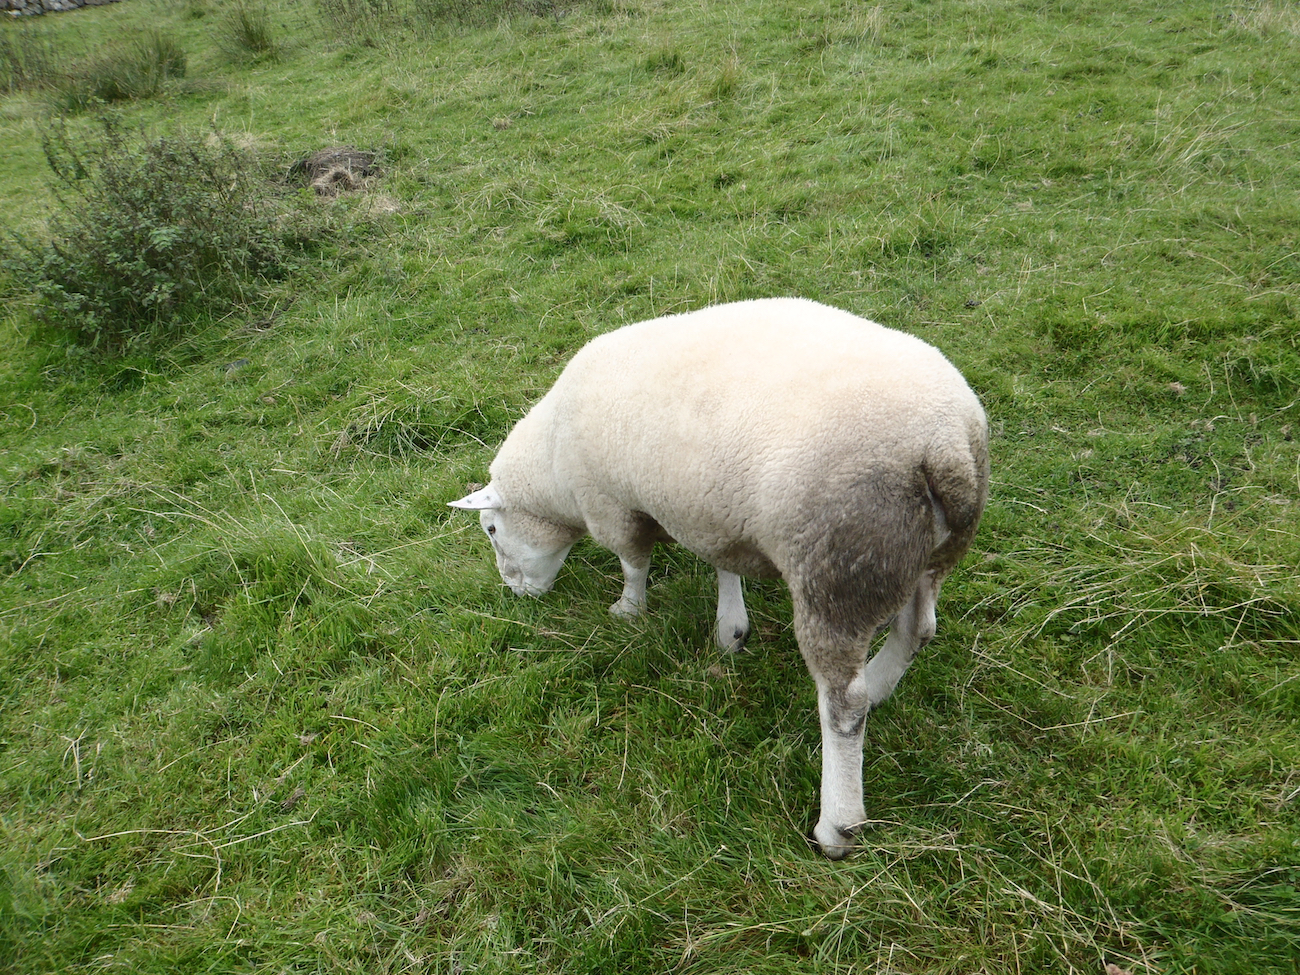

In [6]:
image_path = 'test_images/schaf.jpg'
Image.open(image_path, 'r')

#### Objekterkennung
Das Ursprungsbild wird als Numpy-Array in den Speicher geladen. Damit das Bildformat dem Eingabeformat für den Tensor entspricht, wird dieser in das Format [1, None, None, 3] überführt. Die für die Objekterkennung nötigen Modell-Schichten werden referenziert und der Bild-Tensor wird dem Modell mit feed_dict übergeben. Zu guter Letzt werden dann noch die Objektboxen um das erkannte Objekt gezogen und mit dem entsprechenden Namen (Label) versehen.

In [9]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
      image = Image.open(image_path)
      image_np = load_image_into_numpy_array(image)
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
         
      im = Image.fromarray(image_np)
      im.save("output9.jpg")

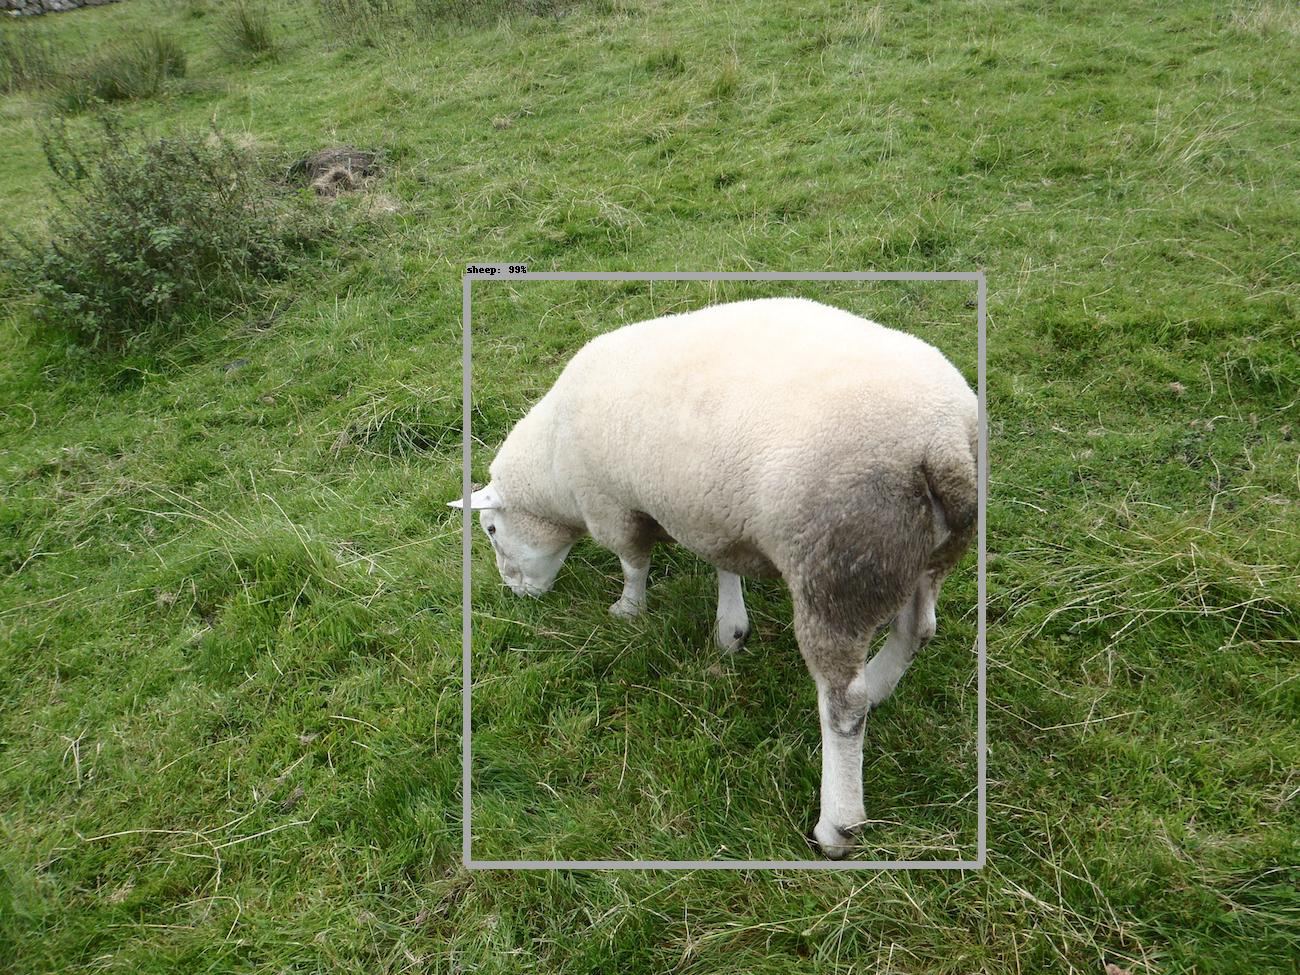

In [10]:
Image.open('./output9.jpg', 'r')